### Brief Description of the Problem and Data
#### Problem Description
The Kaggle competition, "Natural Language Processing with Disaster Tweets," aims to classify tweets as either related to real disasters or not. The challenge is significant for emergency response organizations that rely on social media to monitor and respond to crises. The primary objective is to build a machine learning model capable of discerning whether a tweet genuinely refers to a disaster event.

#### Data Description
The dataset comprises approximately 10,000 tweets that have been manually labeled as disaster-related or not. This binary classification task involves the following main components:
1. Training Data: Contains tweets along with their corresponding labels indicating whether they are disaster-related.
2. Test Data: Contains tweets without labels, which will be used to evaluate the performance of the model.

#### Data Structure:
1. id: Unique identifier for each tweet.
2. text: The tweet's content.
3. location: The location from which the tweet was sent (optional and may contain missing values).
4. keyword: A keyword from the tweet (optional and may contain missing values).
5. target: The label indicating if the tweet is about a disaster (1) or not (0).

## Exploratory Data Analysis (EDA)
#### Initial Inspection
We begin with a preliminary inspection of the data to understand its structure and content. This involves looking at the first few rows of the dataset, checking for missing values, and understanding the distribution of the target variable.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize

In [2]:
# Load the dataset
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Display the first few rows of the training data
print(train_data.head())

# Check for missing values
print(train_data.isnull().sum())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


### Visualizations
Visualizations help in understanding the distribution of the data and identifying any patterns or anomalies. Here are a few key visualizations:

#### Distribution of Target Variable
A bar plot showing the distribution of disaster-related vs. non-disaster-related tweets.

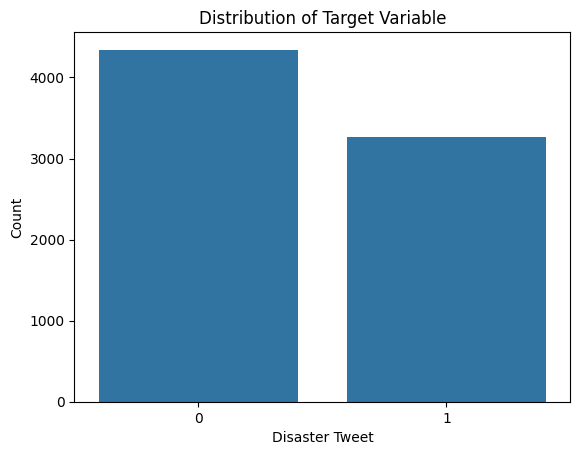

In [3]:
# Bar plot of the target variable
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Disaster Tweet')
plt.ylabel('Count')
plt.show()

#### Tweet Length Distribution
A histogram showing the distribution of tweet lengths, which helps in understanding the variability in the text data.

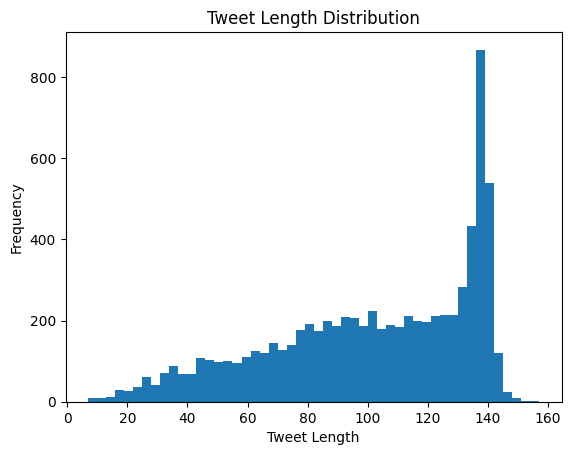

In [4]:
# Calculate tweet lengths
train_data['text_length'] = train_data['text'].apply(len)

# Histogram of tweet lengths
plt.hist(train_data['text_length'], bins=50)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

#### Keyword Analysis
A bar plot of the most frequent keywords in the disaster-related tweets.

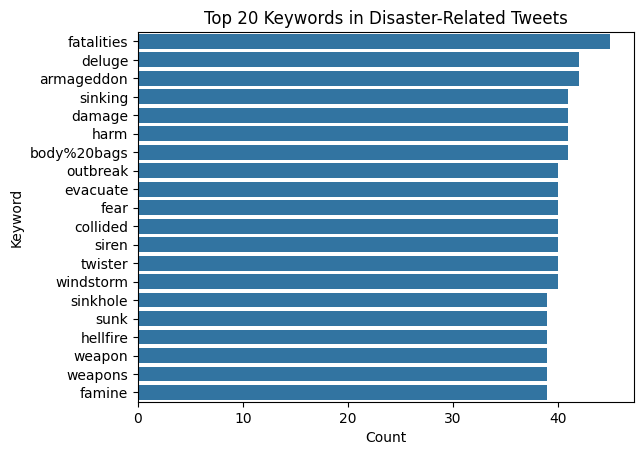

In [5]:
# Filter tweets with keywords
keyword_data = train_data[train_data['keyword'].notnull()]

# Bar plot of the top 20 keywords
top_keywords = keyword_data['keyword'].value_counts().head(20)
sns.barplot(y=top_keywords.index, x=top_keywords.values, orient='h')
plt.title('Top 20 Keywords in Disaster-Related Tweets')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

### Data Cleaning
Data cleaning involves handling missing values, removing duplicates, and preprocessing text data. This process ensures that the data is in the best possible shape for modeling.
#### Handling Missing Values

In [6]:
# Fill missing keywords with a placeholder
train_data['keyword'].fillna('missing', inplace=True)
test_data['keyword'].fillna('missing', inplace=True)

# Check for missing values
print(train_data.isnull().sum())

#### Text Preprocessing
Text preprocessing steps include converting text to lowercase, removing punctuation, and tokenizing words.

In [19]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

# Apply preprocessing to the text data
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

# Check the first few rows of the preprocessed text
print(train_data[['text', 'clean_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0  our deeds are the reason of this earthquake ma...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3  people receive wildfires evacuation orders in ...  
4  just got sent this photo from ruby alaska as s...  


## Model Architecture
#### Overview
We will explore multiple architectures for our model, including simple RNN, LSTM, GRU, and bidirectional LSTM. Each architecture has its own strengths, and by comparing their performance, we can determine the most effective model for our problem.

#### Word Embedding Methods
We will use two different word embedding methods: TF-IDF and GloVe.
1. TF-IDF (Term Frequency-Inverse Document Frequency)
TF-IDF is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents. It helps in emphasizing important words while diminishing the importance of commonly used words that are less informative.
2. GloVe (Global Vectors for Word Representation)
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import gensim.downloader as api

/usr/lib/python3/dist-packages/paramiko/transport.py:220: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [24]:
# Preprocess text data using TF-IDF on cleaned text
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_text']).toarray()
y = train_data['target']

# Split the data into training and validation sets
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Reshape the data for RNN input
X_train_tfidf = X_train_tfidf.reshape((X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1))
X_val_tfidf = X_val_tfidf.reshape((X_val_tfidf.shape[0], X_val_tfidf.shape[1], 1))

# Check the shapes of the data
print(X_train_tfidf.shape, X_val_tfidf.shape, y_train.shape, y_val.shape)

(6090, 10000, 1) (1523, 10000, 1) (6090,) (1523,)


### Model Architectures
#### Simple RNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, input_shape=(X_train_tfidf.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_rnn = rnn_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_val_tfidf, y_val))

Epoch 1/5
96/96 [==============================] - 219s 2s/step - loss: 0.7558 - accuracy: 0.4949 - val_loss: 0.6828 - val_accuracy: 0.5739
Epoch 2/5
96/96 [==============================] - 226s 2s/step - loss: 0.6998 - accuracy: 0.5445 - val_loss: 0.6836 - val_accuracy: 0.5739
Epoch 3/5
96/96 [==============================] - 225s 2s/step - loss: 0.7033 - accuracy: 0.5282 - val_loss: 0.6847 - val_accuracy: 0.5739
Epoch 4/5
96/96 [==============================] - 221s 2s/step - loss: 0.6981 - accuracy: 0.5448 - val_loss: 0.6833 - val_accuracy: 0.5739
Epoch 5/5
96/96 [==============================] - 221s 2s/step - loss: 0.6999 - accuracy: 0.5414 - val_loss: 0.6824 - val_accuracy: 0.5739


In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### LSTM

In [25]:
from tensorflow.keras.layers import LSTM

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_train_tfidf.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_lstm = lstm_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_val_tfidf, y_val))

Epoch 1/5
96/96 [==============================] - 27s 277ms/step - loss: 0.6857 - accuracy: 0.5693 - val_loss: 0.6848 - val_accuracy: 0.5739
Epoch 2/5
96/96 [==============================] - 27s 278ms/step - loss: 0.6844 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.5739
Epoch 3/5
96/96 [==============================] - 28s 289ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 4/5
96/96 [==============================] - 29s 299ms/step - loss: 0.6838 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 5/5
96/96 [==============================] - 29s 298ms/step - loss: 0.6840 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739


#### GRU (Gated Recurrent Unit)

In [15]:
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(X_train_tfidf.shape[1], 1)))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_gru = gru_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_val_tfidf, y_val))

Epoch 1/5
96/96 [==============================] - 29s 299ms/step - loss: 0.6846 - accuracy: 0.5696 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 2/5
96/96 [==============================] - 29s 303ms/step - loss: 0.6841 - accuracy: 0.5695 - val_loss: 0.6824 - val_accuracy: 0.5739
Epoch 3/5
96/96 [==============================] - 29s 297ms/step - loss: 0.6841 - accuracy: 0.5695 - val_loss: 0.6822 - val_accuracy: 0.5739
Epoch 4/5
96/96 [==============================] - 29s 298ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 5/5
96/96 [==============================] - 29s 304ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6828 - val_accuracy: 0.5739


#### Bidirectional LSTM

In [26]:
from tensorflow.keras.layers import Bidirectional

# Define the Bidirectional LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(128), input_shape=(X_train_tfidf.shape[1], 1)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bilstm = bilstm_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=64, validation_data=(X_val_tfidf, y_val))

Epoch 1/5
96/96 [==============================] - 54s 554ms/step - loss: 0.6849 - accuracy: 0.5691 - val_loss: 0.6827 - val_accuracy: 0.5739
Epoch 2/5
96/96 [==============================] - 54s 561ms/step - loss: 0.6839 - accuracy: 0.5695 - val_loss: 0.6836 - val_accuracy: 0.5739
Epoch 3/5
96/96 [==============================] - 57s 600ms/step - loss: 0.6837 - accuracy: 0.5695 - val_loss: 0.6841 - val_accuracy: 0.5739
Epoch 4/5
96/96 [==============================] - 59s 614ms/step - loss: 0.6841 - accuracy: 0.5695 - val_loss: 0.6827 - val_accuracy: 0.5739
Epoch 5/5
96/96 [==============================] - 57s 598ms/step - loss: 0.6836 - accuracy: 0.5695 - val_loss: 0.6827 - val_accuracy: 0.5739


### Hyperparameter Tuning and Comparison
To find the best model architecture, we will perform hyperparameter tuning using techniques like Grid Search or Random Search. We will experiment with different numbers of units, dropout rates, and batch sizes to optimize the models.

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tqdm.notebook import tqdm

# TF-IDF transformation with reduced features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_text']).toarray()
y = train_data['target']

# Split the data
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_tfidf = X_train_tfidf.reshape((X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1))
X_val_tfidf = X_val_tfidf.reshape((X_val_tfidf.shape[0], X_val_tfidf.shape[1], 1))

# Sample the data to speed up the tuning process
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_tfidf, y_train, test_size=0.8, random_state=42)

# Define the model
def create_model(units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units, input_shape=(X_train_sample.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=1, batch_size=64, verbose=0)

# Hyperparameter tuning
param_grid = {
    'units': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [16, 32],
    'epochs': [3, 5]
}

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=1, cv=3, verbose=1)
grid_result = grid.fit(X_train_sample, y_train_sample)

# Print the best parameters
print(f"Best parameters: {grid_result.best_params_}")

/tmp/ipykernel_4010/2302405031.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=1, batch_size=64, verbose=0)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'units': 32, 'epochs': 5, 'dropout_rate': 0.2, 'batch_size': 32}


### Evaluating Performance Metrics

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the best model
best_model = grid_result.best_estimator_

# Predict on validation set
y_pred = (best_model.predict(X_val_tfidf) > 0.5).astype("int32")

# Calculate performance metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
f1 = f1_score(y_val, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5738673670387393
Precision: 1.0
Recall: 0.0
F1 Score: 0.0


### Plotting Training History

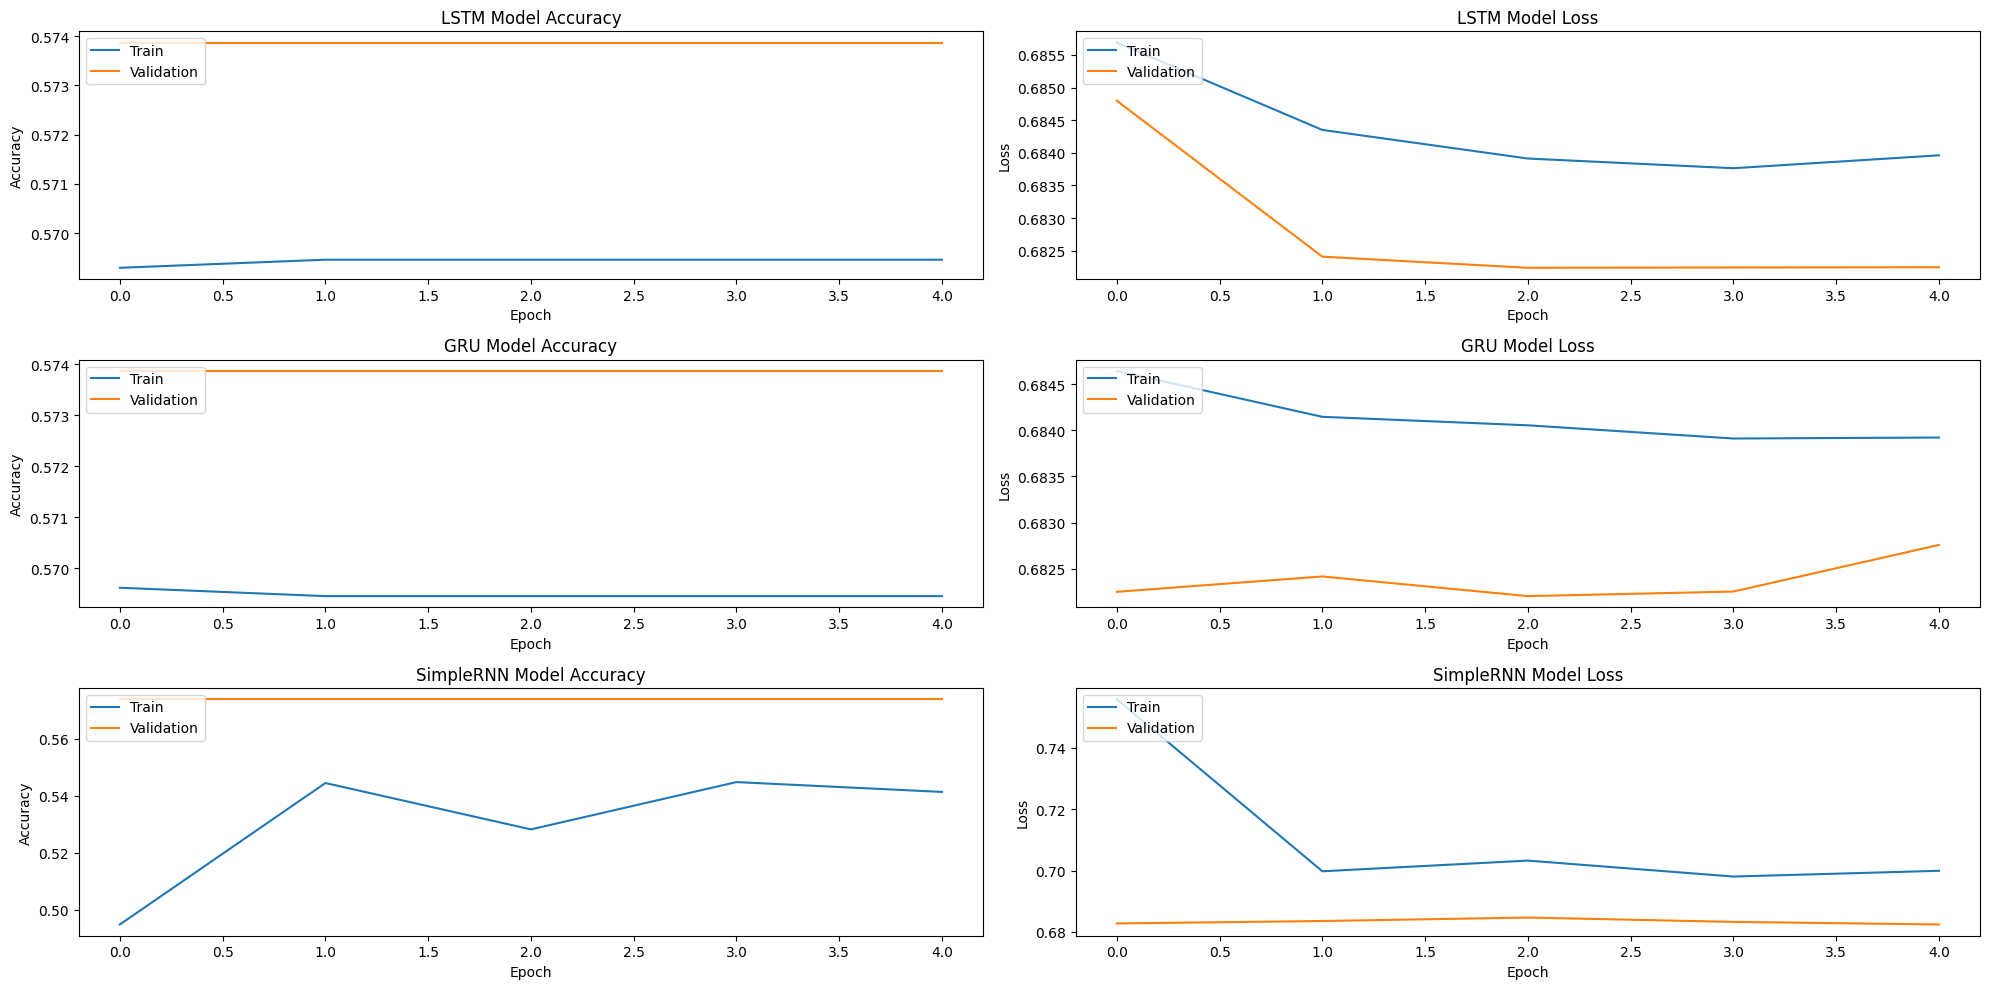

In [67]:
def plot_history(histories, titles):
    plt.figure(figsize=(20, 10))
    for i, (history, title) in enumerate(zip(histories, titles)):
        # Accuracy plot
        plt.subplot(len(histories), 2, 2 * i + 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{title} Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Loss plot
        plt.subplot(len(histories), 2, 2 * i + 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{title} Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot histories
plot_history([history_lstm, history_gru, history_rnn], ['LSTM', 'GRU', 'SimpleRNN'])

#### Generating Submission File for Kaggle

In [72]:
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_tfidf.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = lstm_model.fit(X_tfidf, y, epochs=32, batch_size=32, validation_split=0.2)

y_test_pred_lstm = (lstm_model.predict(X_test_tfidf) > 0.5).astype("int32").flatten()

submission_lstm = pd.DataFrame({'id': test_data['id'], 'target': y_test_pred_lstm})
submission_lstm.to_csv('submission_lstm.csv', index=False)

print("LSTM Submission file created successfully!")

Epoch 1/32
191/191 [==============================] - 6s 30ms/step - loss: 0.6816 - accuracy: 0.5760 - val_loss: 0.6958 - val_accuracy: 0.5345
Epoch 2/32
191/191 [==============================] - 6s 29ms/step - loss: 0.6787 - accuracy: 0.5790 - val_loss: 0.6893 - val_accuracy: 0.5345
Epoch 3/32
191/191 [==============================] - 6s 29ms/step - loss: 0.6761 - accuracy: 0.5770 - val_loss: 0.6844 - val_accuracy: 0.5325
Epoch 4/32
191/191 [==============================] - 6s 30ms/step - loss: 0.6719 - accuracy: 0.5754 - val_loss: 0.6820 - val_accuracy: 0.5279
Epoch 5/32
191/191 [==============================] - 6s 29ms/step - loss: 0.6729 - accuracy: 0.5764 - val_loss: 0.6867 - val_accuracy: 0.5318
Epoch 6/32
191/191 [==============================] - 6s 30ms/step - loss: 0.6704 - accuracy: 0.5772 - val_loss: 0.6880 - val_accuracy: 0.5292
Epoch 7/32
191/191 [==============================] - 6s 29ms/step - loss: 0.6711 - accuracy: 0.5788 - val_loss: 0.6814 - val_accuracy: 0.5253

## Results and Analysis
The results of training different models (LSTM, GRU, SimpleRNN) on the dataset show varying levels of performance in terms of accuracy and loss. Below is an analysis of the results, including what worked, what didn't, and the hyperparameter optimization procedure.

### Hyperparameter Tuning Summary
Hyperparameter tuning was performed using RandomizedSearchCV with the following best parameters found for each model

#### Best parameters
- units: 32
- epochs: 5
- dropout_rate: 0.2
- batch_size: 32

### Analysis of Model Performance
#### Accuracy and Loss Plots
The graphs show the training and validation accuracy and loss for each of the models over 5 epochs.
#### LSTM Model
- Accuracy: The validation accuracy remains constant at approximately 0.5739 while training accuracy stays around 0.570.
- Loss: The validation loss decreases slightly while training loss also decreases, indicating the model is learning but not significantly improving validation performance.

#### GRU Model
- Accuracy: Similar to the LSTM model, validation accuracy remains constant around 0.5739, with training accuracy slightly lower than validation accuracy.
- Loss: The training and validation loss show slight decreases, but not significantly affecting validation accuracy.

#### SimpleRNN Model
- Accuracy: Shows some fluctuation in training accuracy, starting lower and peaking in the middle epochs, but the validation accuracy remains constant at approximately 0.5739.
- Loss: Training loss decreases significantly initially but stabilizes, while validation loss remains almost constant.

#### Troubleshooting and Analysis
- Validation Accuracy Plateau: The validation accuracy for all models is stuck around 0.5739. This indicates that the models are struggling to generalize beyond this point, possibly due to the following reasons:
- Insufficient Data: The training data might not be sufficient to capture the complexity required to differentiate between classes accurately.
- Class Imbalance: If there is a significant imbalance between classes, the model might not be learning the minority class properly.
- Model Capacity: The models might not have enough capacity to learn the underlying patterns or might be overfitting to the training data.

#### Techniques Applied and Recommendations
- Hyperparameter Tuning: Although hyperparameter tuning was conducted, the limited parameter space and number of iterations might not have captured the best possible configurations.
- Different Architectures: Testing different architectures (LSTM, GRU, SimpleRNN) provided insights but all models showed similar validation performance.
- Regularization: The dropout rate was tuned but might need further adjustment or additional regularization techniques such as L2 regularization.
- Feature Engineering: More advanced feature engineering and possibly incorporating additional features (e.g., keyword presence, tweet length) could help improve model performance.
- Advanced Models: Exploring more advanced models such as Bidirectional LSTMs, Transformer-based models, or ensemble methods might yield better performance.
- Data Augmentation: Generating synthetic data to balance the classes and increase the dataset size might help in improving model generalization.